In [1]:
import os
import random
import string
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm
from io import BytesIO
from toolz.curried import *
import requests

In [2]:
! pip install fonttools
from fontTools.ttLib import TTFont
from fontTools.unicode import Unicode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 13.9 MB/s 


In [ ]:
paths = {
  'fonts': os.path.join('ocr-digital-display','synthetic-data-generation', 'fonts')
}

In [ ]:
def get_wordlist():
  word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
  response = requests.get(word_site)
  return response.content.splitlines()

WORDS = get_wordlist()
ALPHAS = [':', '.'] # TODO: &

def char_list():
  return concatv(
      string.ascii_letters,
      string.digits,
      ALPHAS
  )

def supported_chars(ttfont):
  return pipe(
    ttfont,
    lambda f: f['cmap'].tables,
    map(lambda x: x.cmap.items()),
    merge,
    lambda d: list(d.keys()),
    filter(lambda char_code: chr(char_code) in char_list()),
    list
  )

def is_supported(charset, font):
  return set(
      map(ord)(charset)
    ).issubset(supported_chars(font))
    
def random_string_from_charset(charset):
  return pipe(
      range(random.randrange(5,15)),
      map(lambda _: random.choice(charset)),
      reduce(lambda a, b: str(a) + str(b)),
  )

def random_digits():
  return random_string_from_charset(string.digits)

def random_word():
  return pipe(
      WORDS,
      random.choice,
      lambda bs: bs.decode("utf-8") 
  )

# TODO: test curry
def supported_filter(font):
  def test(string):
    return is_supported(string, font)
  return test

def sample_text(font):
  return pipe([
      random_string_from_charset(list(string.digits) + ALPHAS),
      random_word(),
      random_digits()
    ],
    filter(supported_filter(font)),
    list,
    random.choice
  )

In [ ]:
# TODO: unused
def is_digits_supported(font):
  return is_supported(string.digits, font)

# TODO: unused
def is_letters_supported(font):
  return is_supported(string.ascii_letters, font)

# TODO: unused
def is_alphas_supported(font):
  return is_supported(ALPHAS, font)

# TODO: unused
def random_gibberish(font):
  return pipe(
      range(random.randrange(5,15)),
      map(lambda _: chr(random.choice(supported_chars(font)))),
      reduce(lambda a, b: str(a) + str(b)),
  )

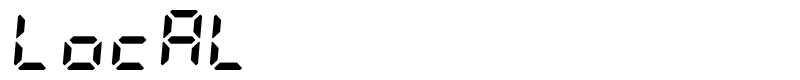

local


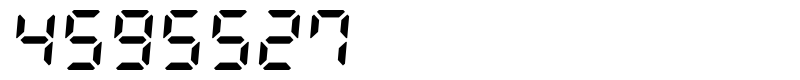

4595527


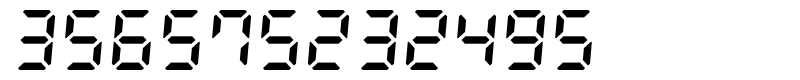

356575232495


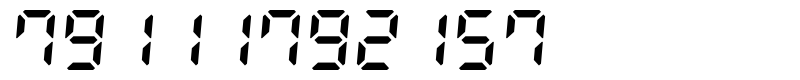

79111792157


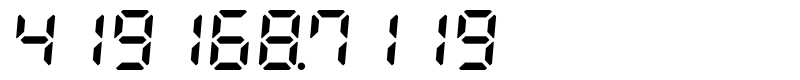

419168.7119


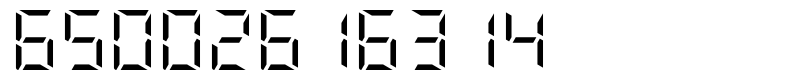

65002616314


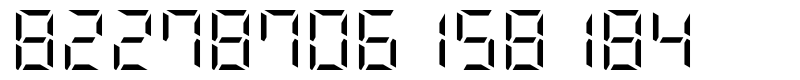

82278706158184


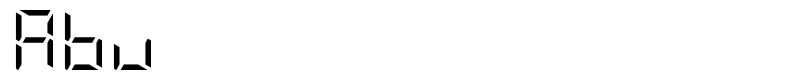

abu


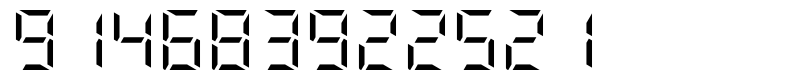

914683922521


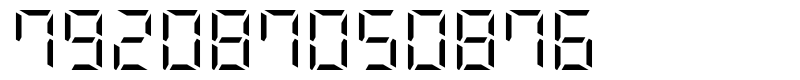

792087050876


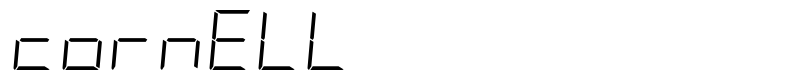

cornell


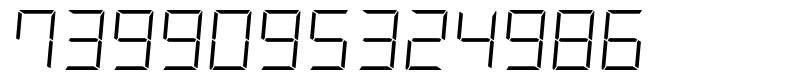

7399095324986


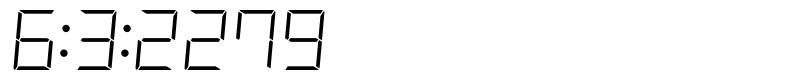

6:3:2279


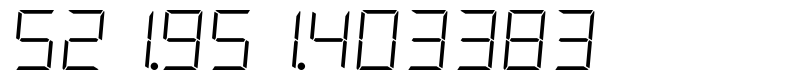

521.951.403383


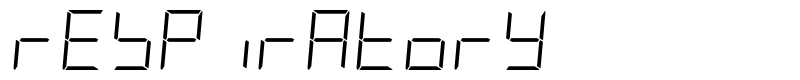

respiratory


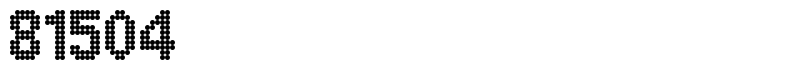

81504


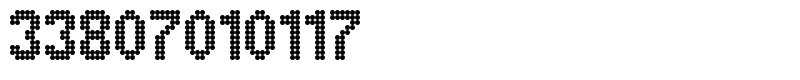

33807010117


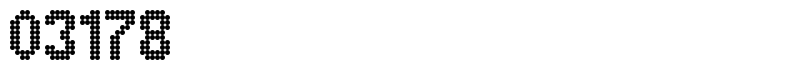

03178


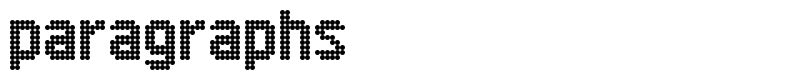

paragraphs


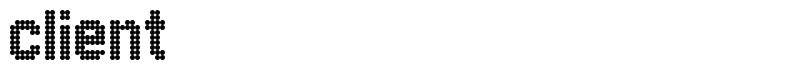

client


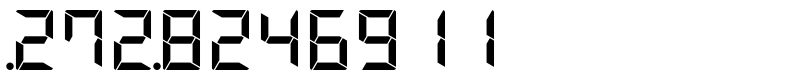

.272.8246911


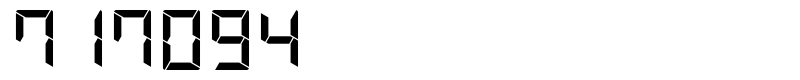

717094


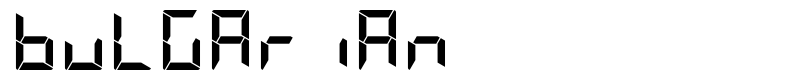

bulgarian


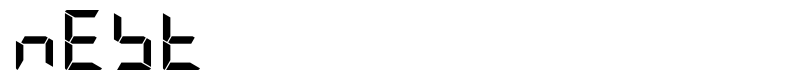

nest


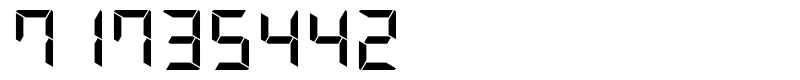

71735442


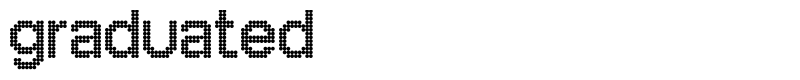

graduated


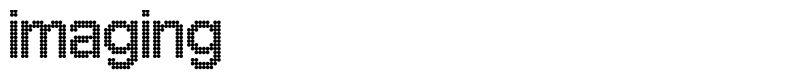

imaging


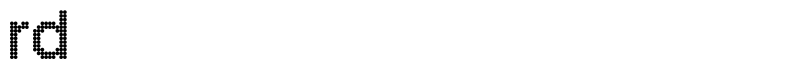

rd


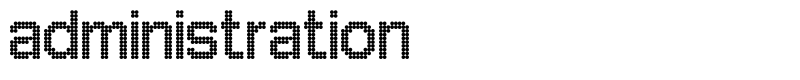

administration


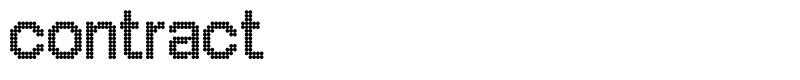

contract


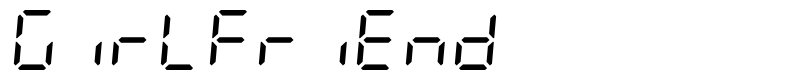

girlfriend


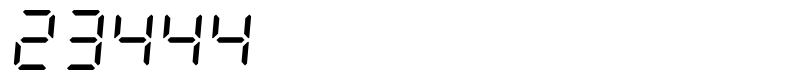

23444


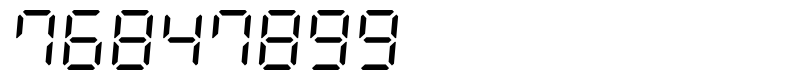

76847899


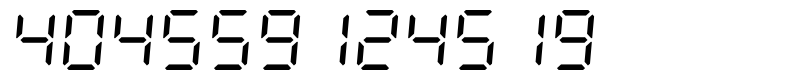

404559124519


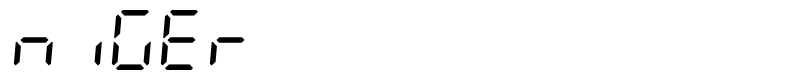

niger


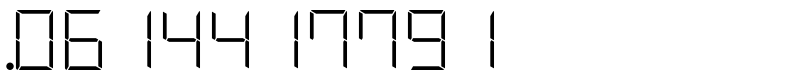

.0614417791


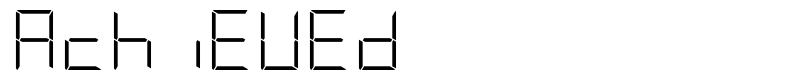

achieved


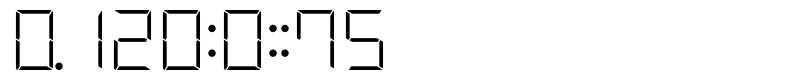

0.120:0::75


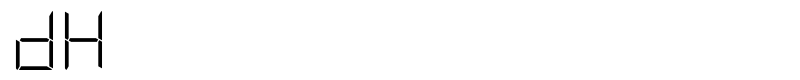

dx


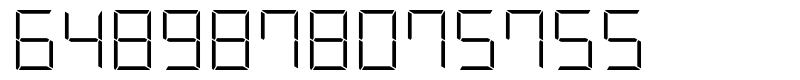

6489878075755


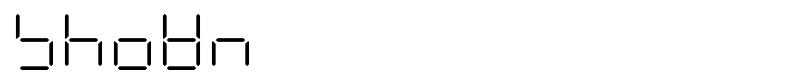

shown


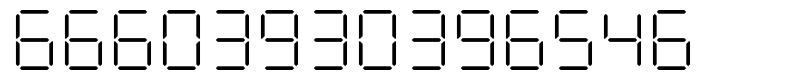

66603930396546


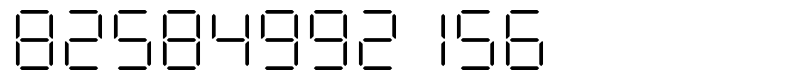

82584992156


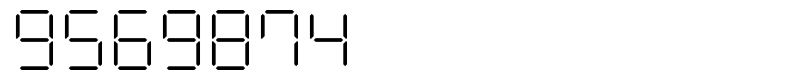

9569874


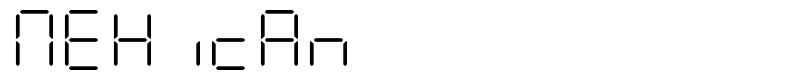

mexican


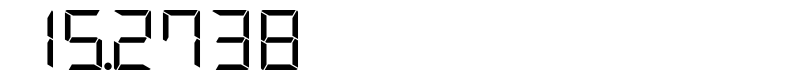

15.2738


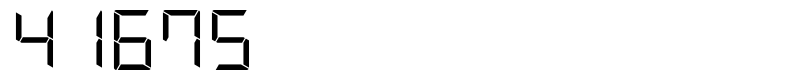

41675


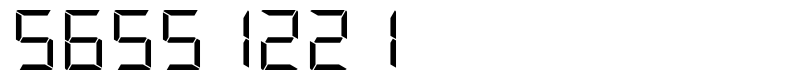

56551221


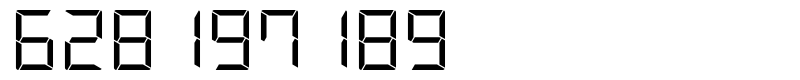

628197189


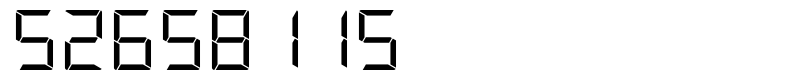

52658115


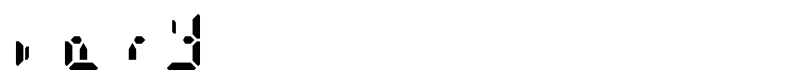

vary


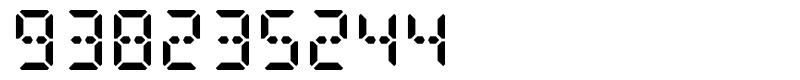

938235244


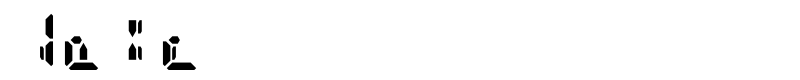

jake


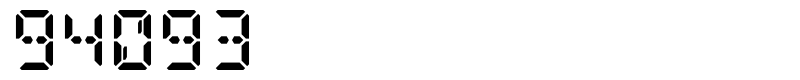

94093


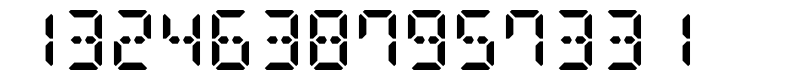

13246387957331


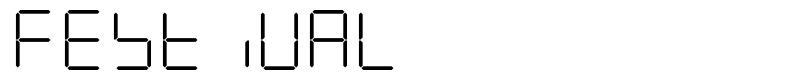

festival


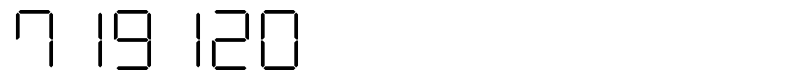

719120


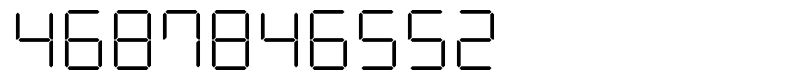

4687846552


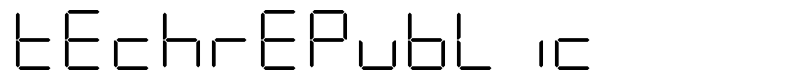

techrepublic


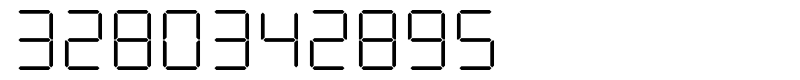

3280342895


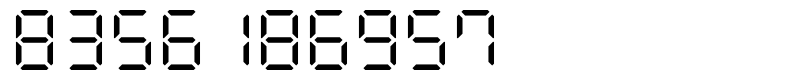

8356186957


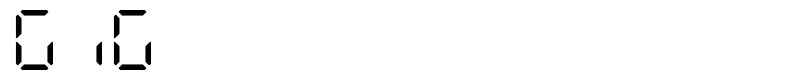

gig


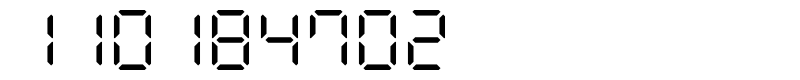

110184702


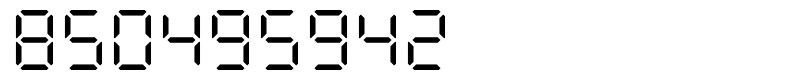

850495942


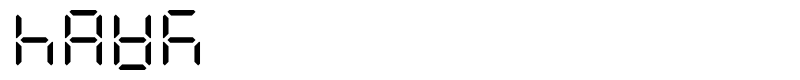

hawk


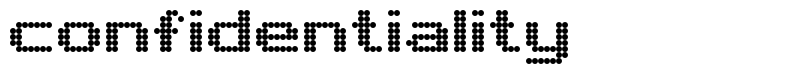

confidentiality


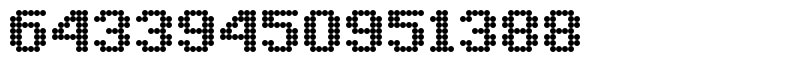

64339450951388


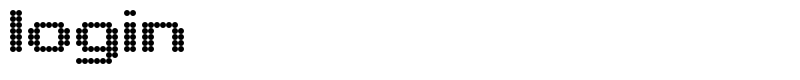

login


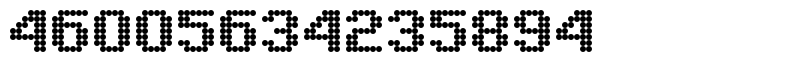

46005634235894


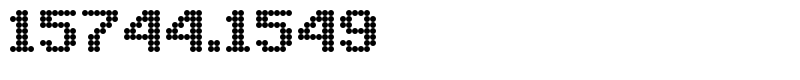

15744.1549


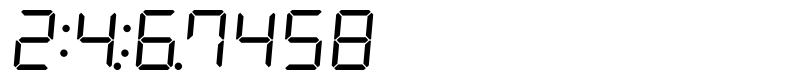

2:4.:6.7458


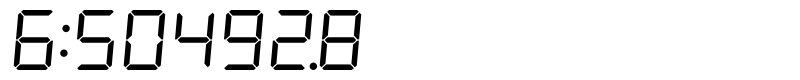

6:50492.8


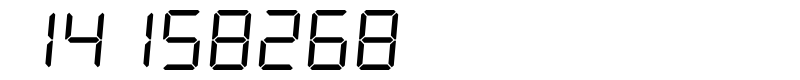

14158268


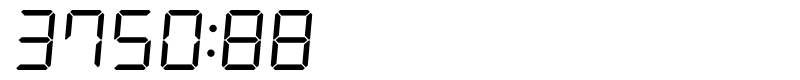

3750:88


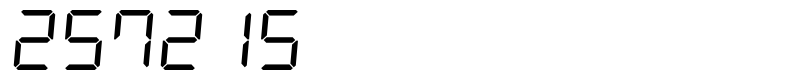

257215


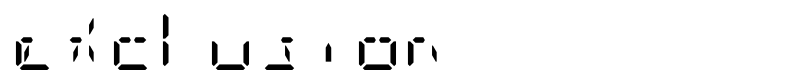

exclusion


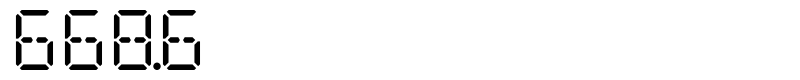

668.6


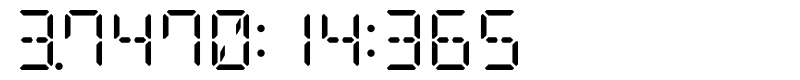

3.7470:14:365


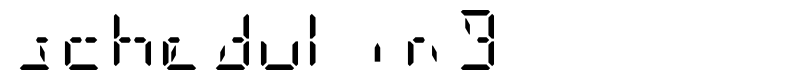

scheduling


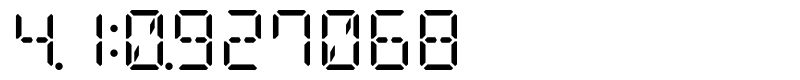

4.1:0.927068


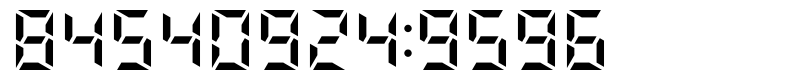

84540924:9596


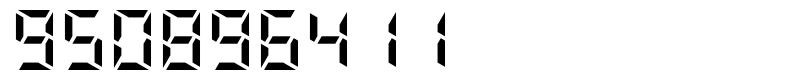

950896411


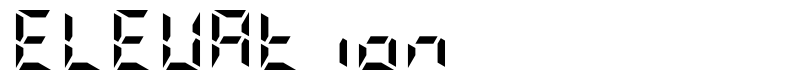

elevation


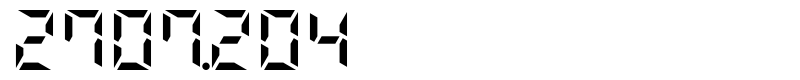

2707.204


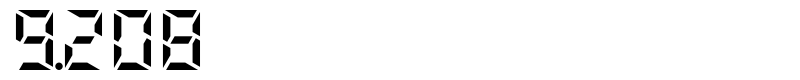

9.208


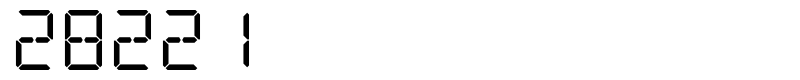

28221


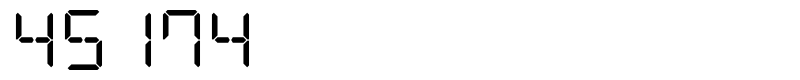

45174


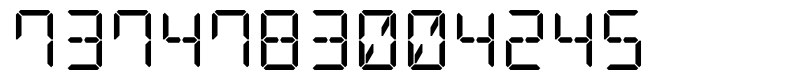

7374783004245


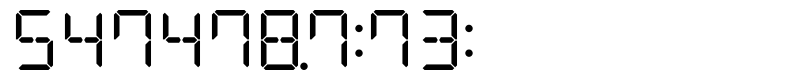

547478.7:73:


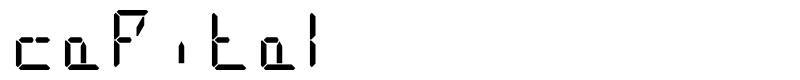

capital


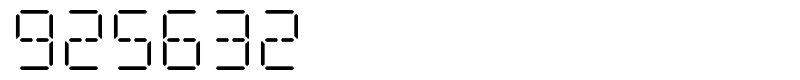

925632


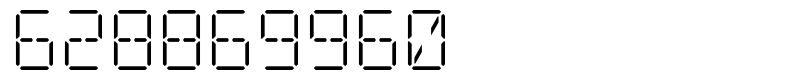

628869960


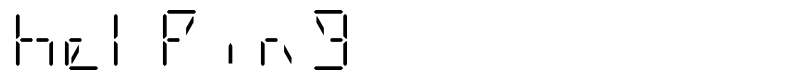

helping


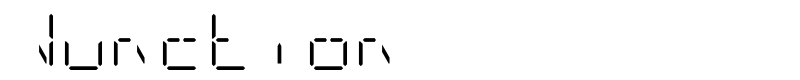

junction


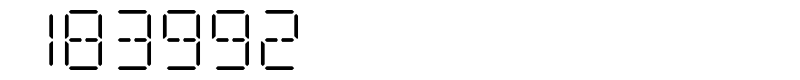

183992


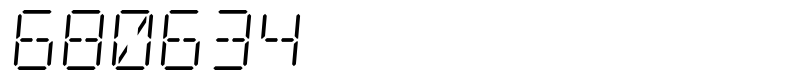

680634


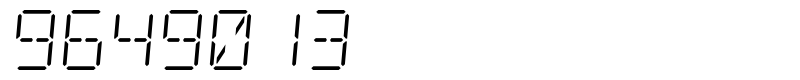

9649013


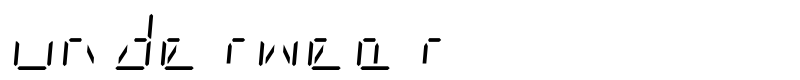

underwear


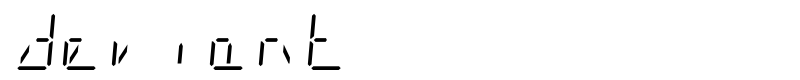

deviant


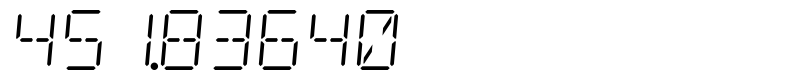

451.83640


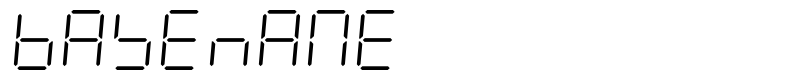

basename


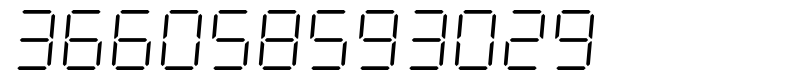

366058593029


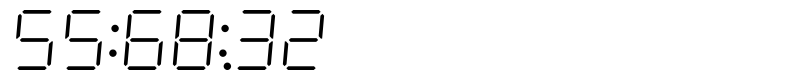

55:68:.32


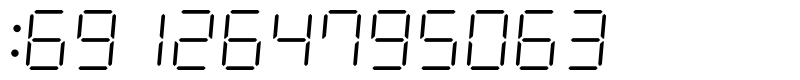

:691264795063


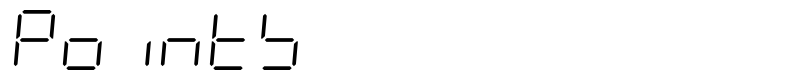

points


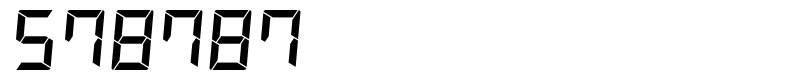

578787


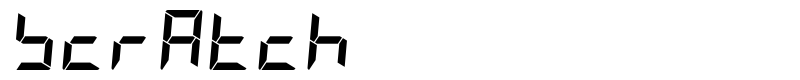

scratch


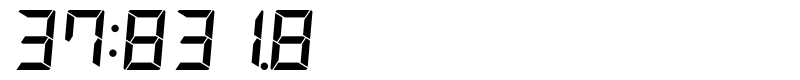

37:831.8


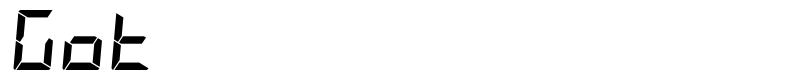

got


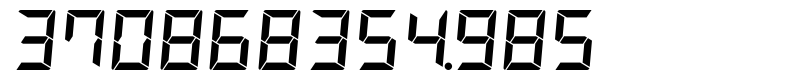

370868354.985


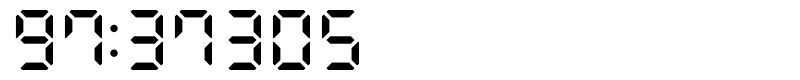

97:37305


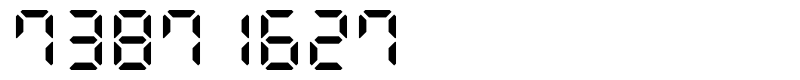

73871627


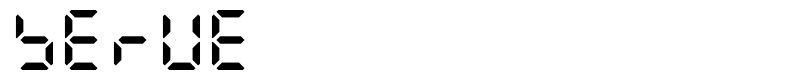

serve


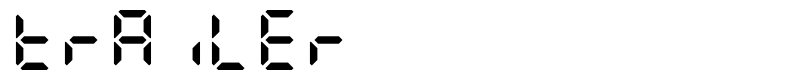

trailer


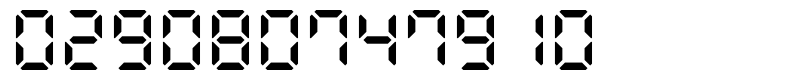

029080747910


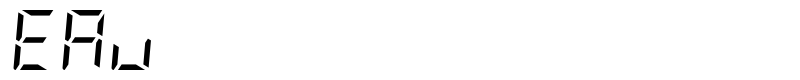

eau


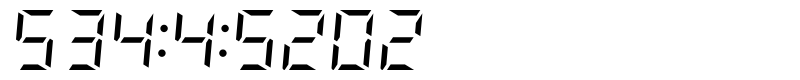

534:4:5202


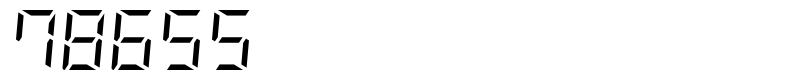

78655


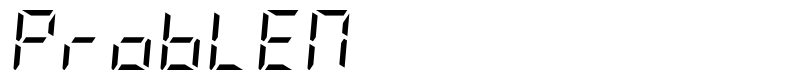

problem


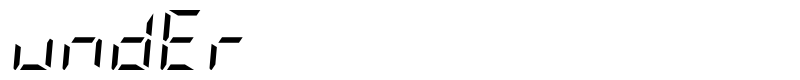

under


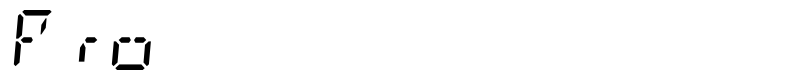

pro


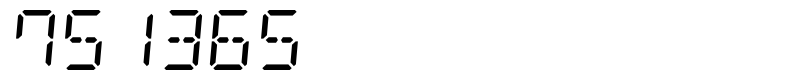

751365


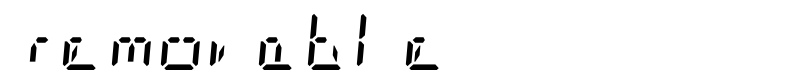

removable


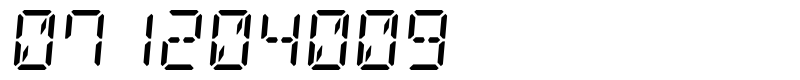

071204009


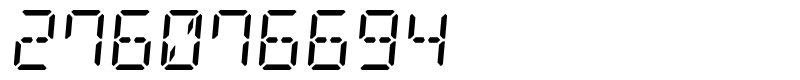

276076694


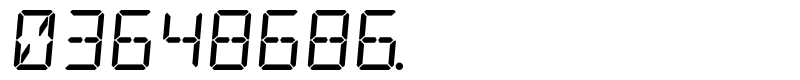

03648686.


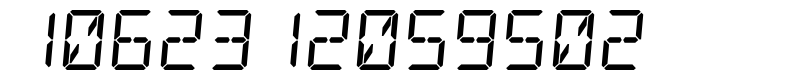

1062312059502


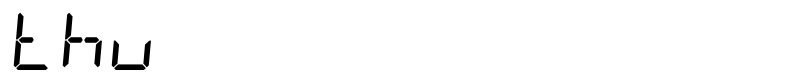

thu


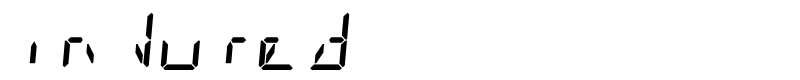

injured


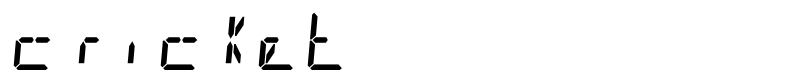

cricket


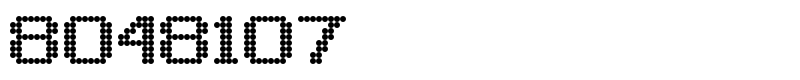

8048107


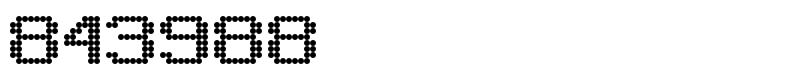

843988


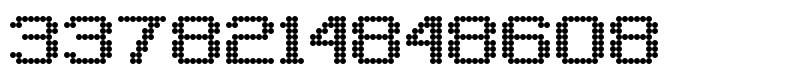

3378214848608


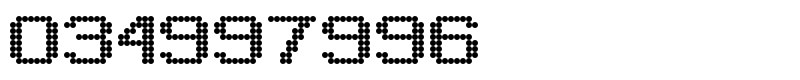

034997996


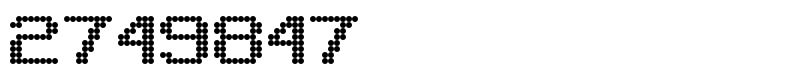

2749847


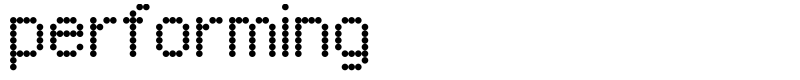

performing


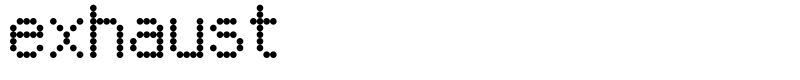

exhaust


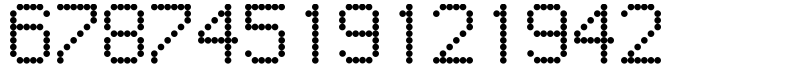

67874519121942


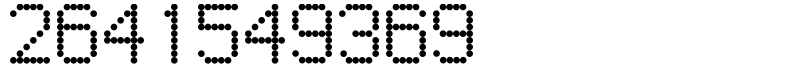

2641549369


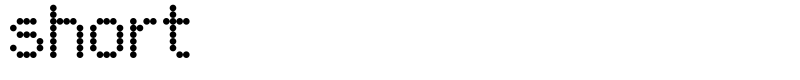

short


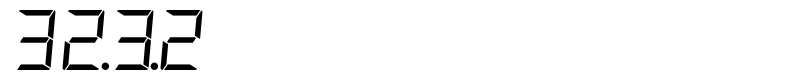

32.3.2


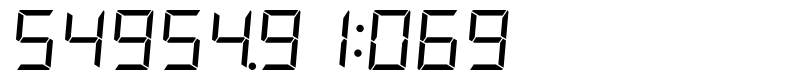

54954.91:069


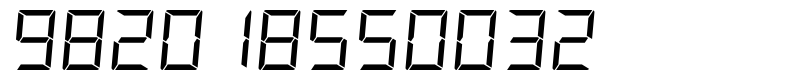

982018550032


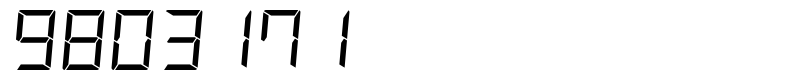

9803171


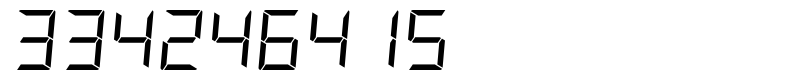

334246415


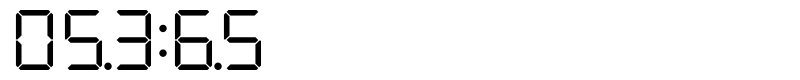

05.3:6.5


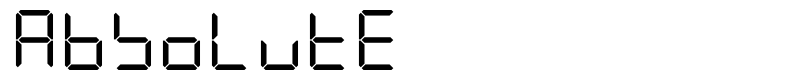

absolute


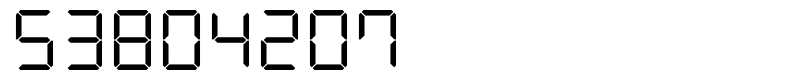

53804207


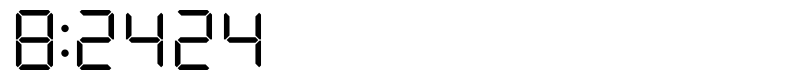

8:2424


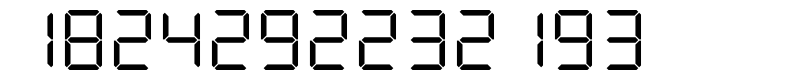

1824292232193


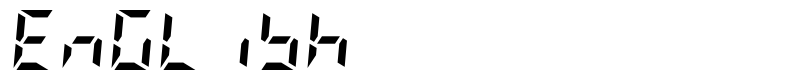

english


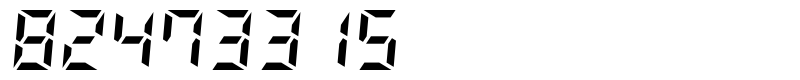

82473315


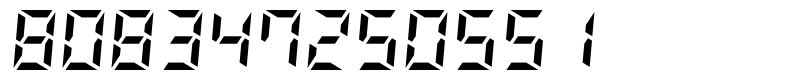

808347250551


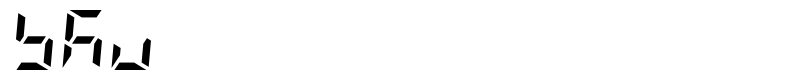

sku


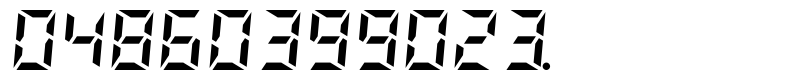

04860399023.


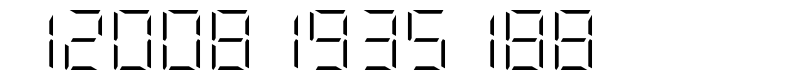

120081935188


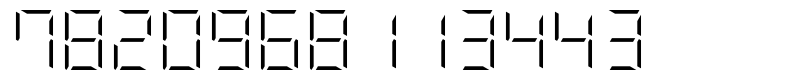

7820968113443


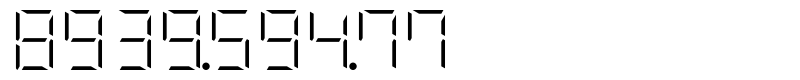

8939.594.77


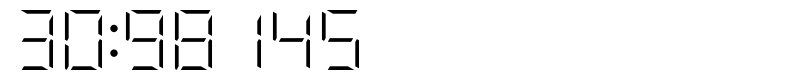

30:98145


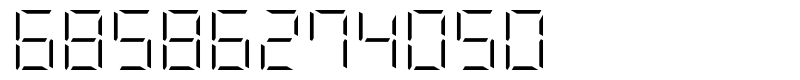

68586274050


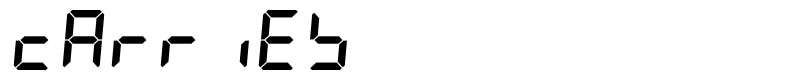

carries


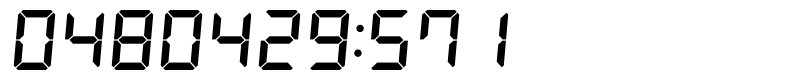

0480429:571


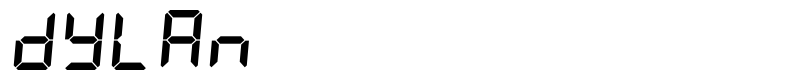

dylan


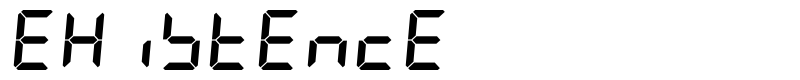

existence


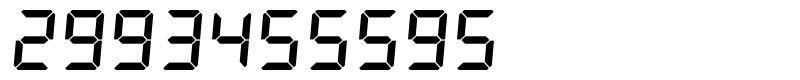

2993455595


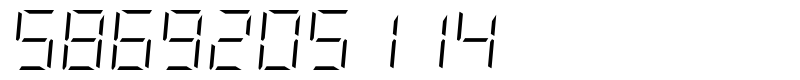

5869205114


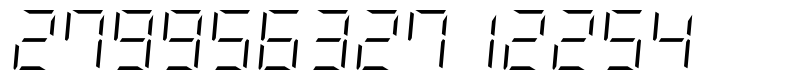

27995632712254


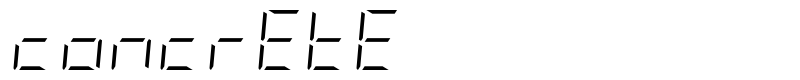

concrete


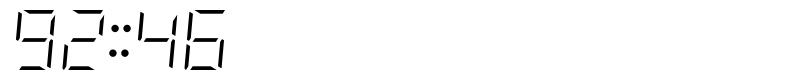

92::46


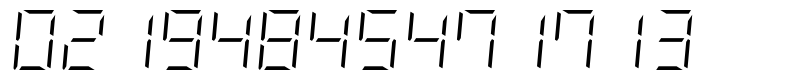

02194845471713


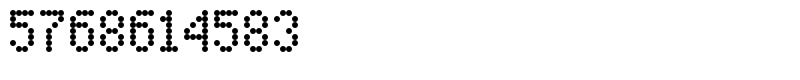

5768614583


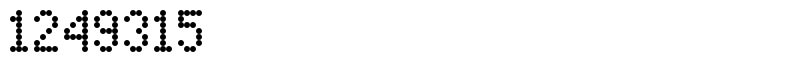

1249315


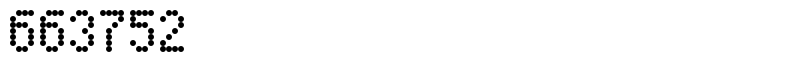

663752


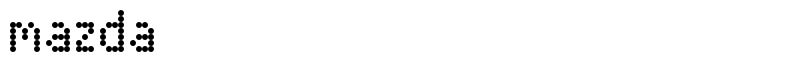

mazda


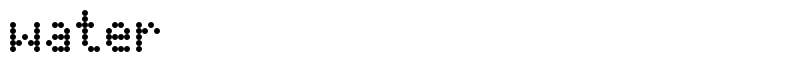

water


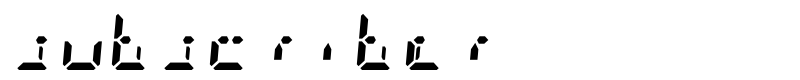

subscriber


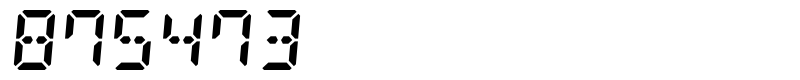

875473


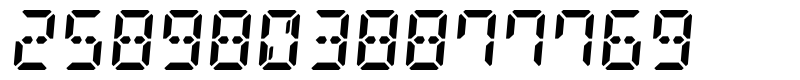

25898038877769


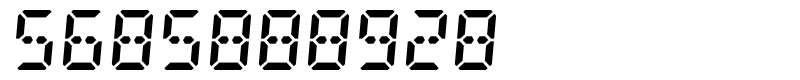

5685888928


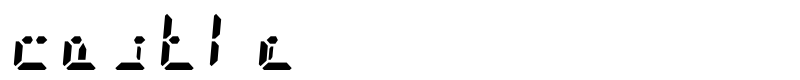

castle


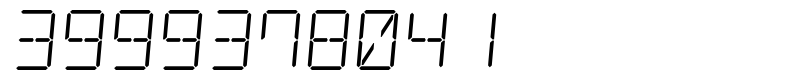

3999378041


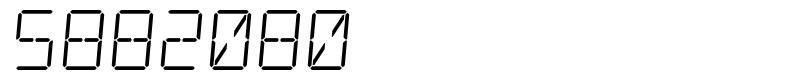

5882080


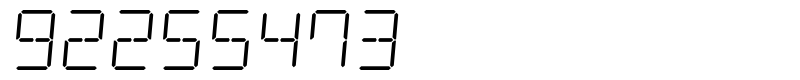

92255473


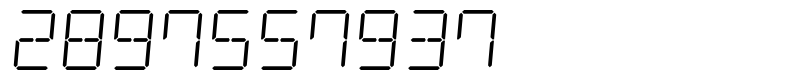

2897557937


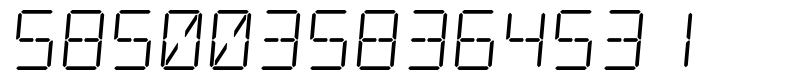

58500358364531


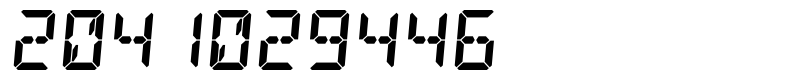

2041029446


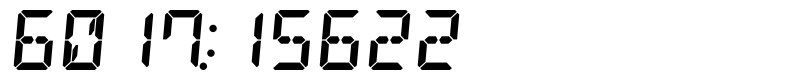

6017...:15622


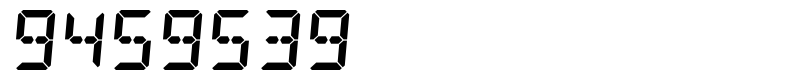

9459539


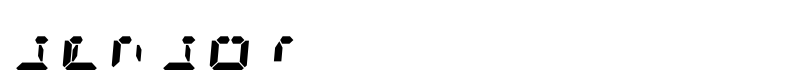

sensor


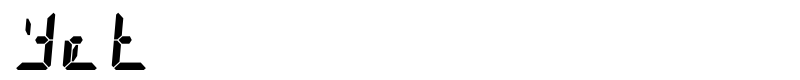

yet


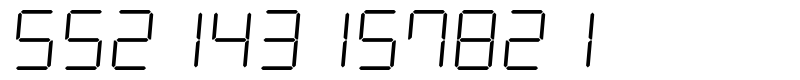

552143157821


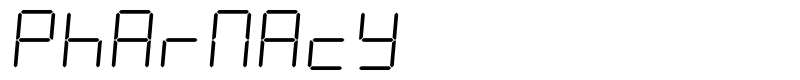

pharmacy


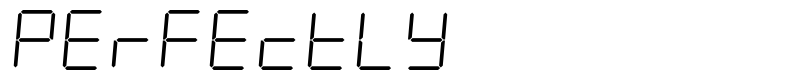

perfectly


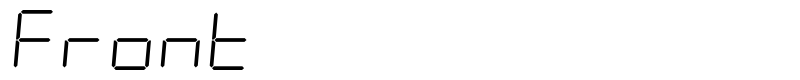

front


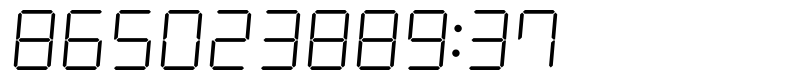

865023889:37


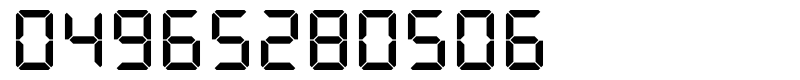

04965280506


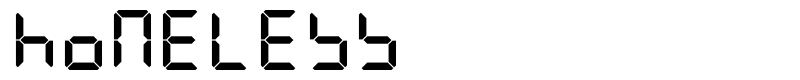

homeless


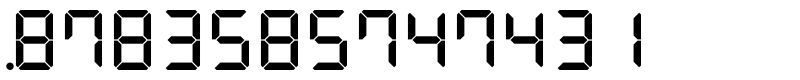

.8783585747431


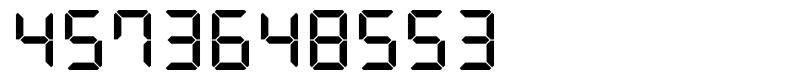

4573648553


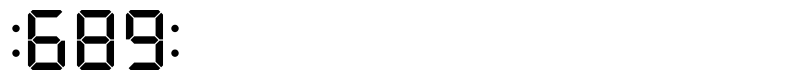

:689:


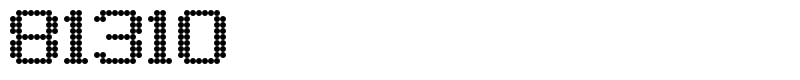

81310


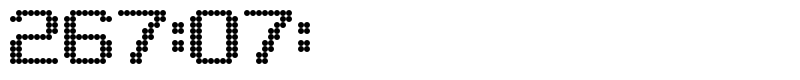

267:07:


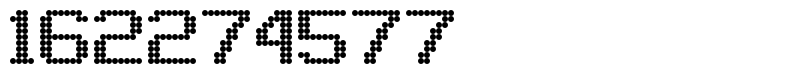

162274577


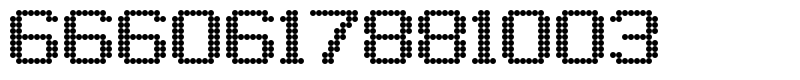

6660617881003


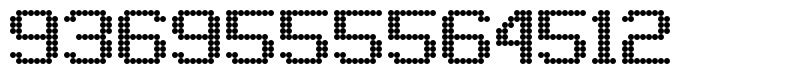

9369555564512


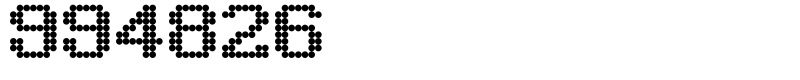

994826


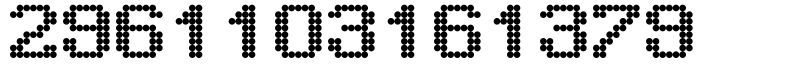

2961103161379


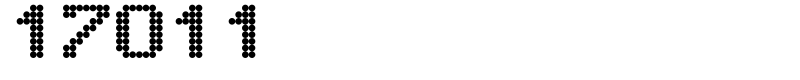

17011


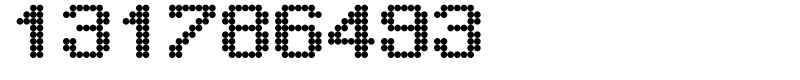

131786493


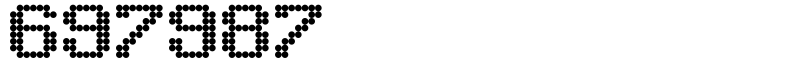

697987


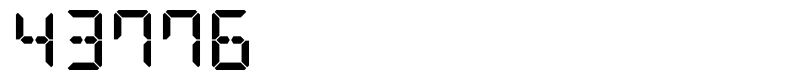

43776


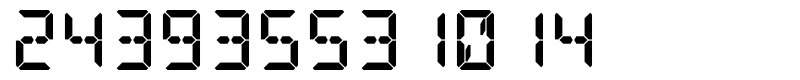

243935531014


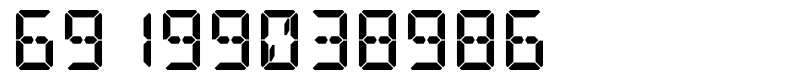

69199038986


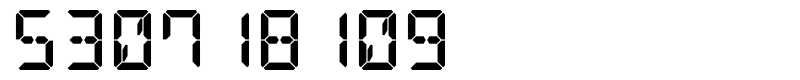

530718109


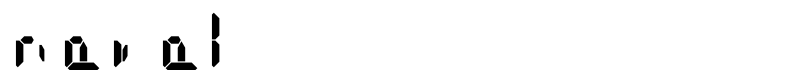

naval


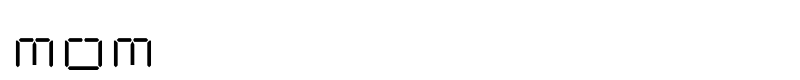

mom


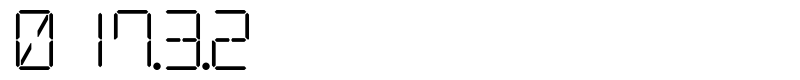

017.3.2


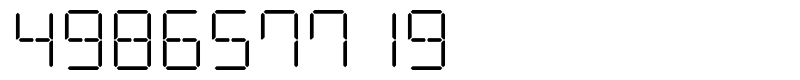

498657719


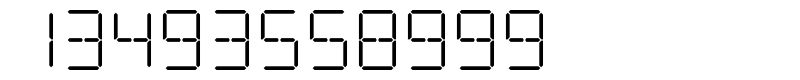

13493558999


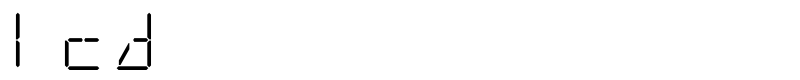

lcd


In [ ]:
def draw_sample(font_path):
  word = sample_text(TTFont(font_path))
  font = ImageFont.truetype(font_path, 60)
  img = Image.new("RGBA", (800,80),(255,255,255))
  draw = ImageDraw.Draw(img)
  draw.text((10, 10),word,(0,0,0),font=font)
  draw = ImageDraw.Draw(img)
  return {'img': img, 'text': word}

def generate_data(fonts, sample_count):
  return pipe(
      fonts,
      mapcat(lambda font: pipe(
          range(sample_count),
          map(draw_sample(font)),
      )),
  )

font_paths = map(lambda f: os.path.join(paths['fonts'], f))(os.listdir(paths['fonts']))

for d in generate_data2(font_paths, 5):
  display(d['img'])
  print(d['text'])